# Imports

In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sb
import sklearn
import scvi
import matplotlib.pyplot as plt

/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


# Data loading

In [3]:
adata_mc = ad.read_h5ad('../../data/daniocell2023_gastrulation.metacells.h5ad')
print(f"Full: {adata_mc.n_obs} metacells, {adata_mc.n_vars} genes")
adata_mc.obs.head(1)

Full: 1010 metacells, 28833 genes


,grouped,total_umis,__zeros_downsample_umis,metacells_rare_gene_module,rare_metacell,u,v,w,x,y,hpf,cell_type
M0.75,49,306329,3244,-1,False,4.653786,1.381917,2.338467,6.311879,10.662604,7.230612,Paraxial mesoderm


In [4]:
full_raw = ad.read_h5ad('../../data/daniocell2023_gastrulation.cells.h5ad')
print(f"Full: {full_raw.n_obs} cells, {full_raw.n_vars} genes")
full_raw.obs.head(1)

Full: 35705 cells, 28833 genes


,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,method,sample,hpf,hpf.nice,stage.group,subset.full,...,excluded_cell,full_cell_index,metacell,dissolved,metacell_level,cells_rare_gene_module,rare_cell,metacell_name,most_similar,cell_type
ZFHIGH_WT_DS5_AAAAGTTGCCTC,10273.0,3311,0.515916,1.479607,dropseq,ZFHIGH-DS5,3.3,3,3-4,blastomeres,...,False,0,907,False,1,-1,False,M907.77,-1,Blastomeres


# Anndata preprocessing (selecting genes)

In [5]:
full_prepro = full_raw.copy()

In [6]:
selected_gene_mask = full_raw.var['selected_gene']
selected_gene_mask.value_counts()

selected_gene
False    25391
True      3442
Name: count, dtype: int64

In [7]:
full_prepro = full_raw[:,selected_gene_mask]

In [8]:
full_prepro.layers['counts'] = full_prepro.X.copy()

/tmp/ipykernel_110617/1203288335.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  full_prepro.layers['counts'] = full_prepro.X.copy()


# scVI

## scVI setup (skip if already done)

In [8]:
scvi.model.SCVI.setup_anndata(full_prepro, layer='counts')
scvi_model = scvi.model.SCVI(full_prepro)
scvi_model.view_anndata_setup(full_prepro)

/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


Anndata setup with scvi-tools version 1.3.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 35705 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 3442  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

## Train model

In [9]:
scvi_model.train(accelerator='auto',train_size=.9,early_stopping=True)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your

Epoch 224/224: 100%|██████████| 224/224 [53:35<00:00, 14.40s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=1.84e+3]

`Trainer.fit` stopped: `max_epochs=224` reached.


Epoch 224/224: 100%|██████████| 224/224 [53:35<00:00, 14.36s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=1.84e+3]


## Save trained state

In [10]:
scvi_model.save('../../data/scvi_models/scvi_model_selectedGenes')

## Load trained state (if reloading notebook)

In [9]:
scvi_model = scvi.model.SCVI.load('../../data/scvi_models/scvi_model_selectedGenes',adata=full_prepro)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../../data/scvi_models/scvi_model_selectedGenes/model.pt already downloaded                          


/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10 ...
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


## Latent representation

In [10]:
full_prepro.obsm['latent_10'] = scvi_model.get_latent_representation(full_prepro)

In [11]:
latent_10_df = pd.DataFrame(full_prepro.obsm['latent_10'], index=full_prepro.obs.index)

In [12]:
latent_10_df.head(2)

,0,1,2,3,4,5,6,7,8,9
ZFHIGH_WT_DS5_AAAAGTTGCCTC,0.590289,-2.860728,0.922139,2.469227,-0.236536,-1.747580,-0.659057,1.413443,-0.063307,0.921091
ZFHIGH_WT_DS5_AAACAAGTGTAT,0.086312,-3.385365,1.278993,2.529145,0.035406,-1.831529,-2.447444,1.712619,-0.811081,1.778821


In [13]:
full_prepro.obsm['latent_10'].shape

(35705, 10)

# Visualization

## UMAP

In [14]:
import umap

In [15]:
umap_model = umap.UMAP(n_neighbors=8, min_dist=.3, n_components=2, random_state=42)
umap_data = umap_model.fit_transform(full_prepro.obsm['latent_10'])
umap_df = pd.DataFrame(umap_data, index=full_prepro.obs.index)
umap_df['cell_type'] = full_prepro.obs['cell_type']

/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jkaatz/miniforge3/envs/scvi_new/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
df_colors = pd.read_csv("../../data/farrell_cell_type_colors.csv")
color_dict = dict(zip(df_colors["cell_type"], df_colors["color"]))
color_dict["Enveloping layer"] = color_dict.pop("EVL")
color_dict["Primordial germ cells"] = color_dict.pop("PGC")
color_dict["Deep cell layer"] = color_dict.pop("DEL")

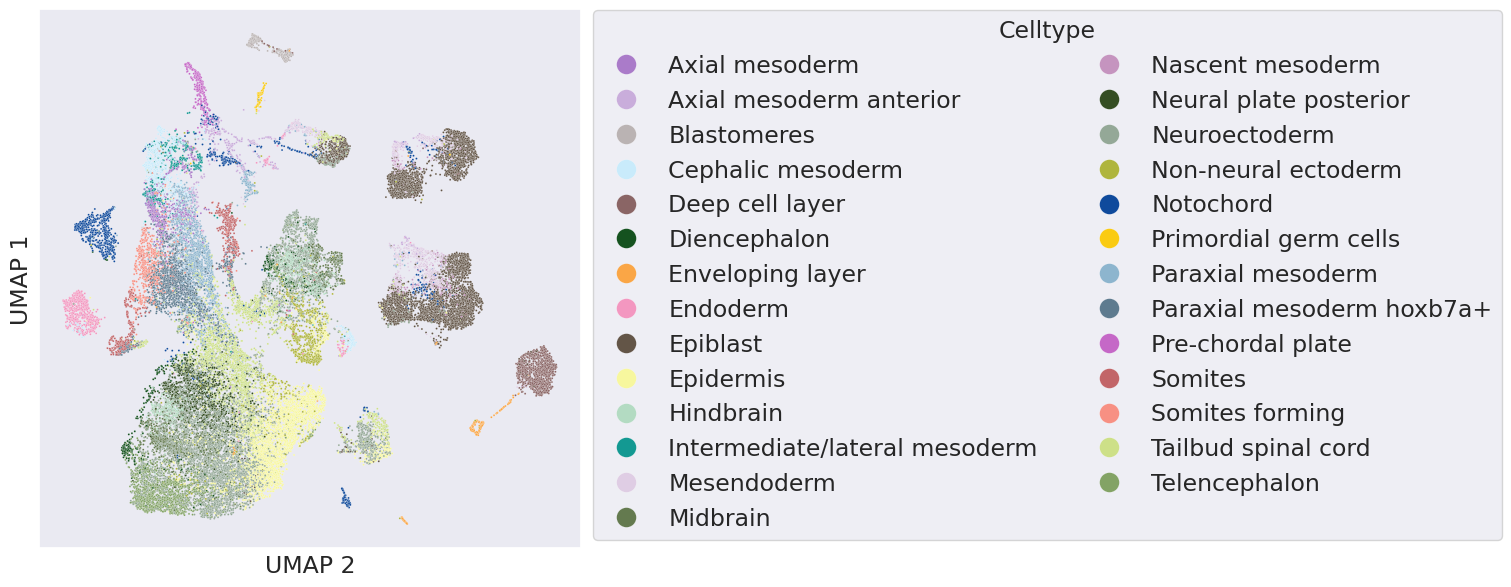

In [23]:
sb.set_theme()

plt.figure(figsize=(7, 7))

ax = sb.scatterplot(x=umap_df[0], y=umap_df[1], s=2, hue=umap_df['cell_type'], palette=color_dict, legend=True)

# annotations
plt.xticks([],fontsize=17)
plt.xlabel("UMAP 2", fontsize=17)
plt.ylabel("UMAP 1", fontsize=17)
plt.yticks([],fontsize=17)

# legend configuration
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.02), fontsize=17, ncol=2, markerscale=10)
ax.get_legend().set_title("Celltype", prop={'size': 17})

plt.savefig('../../figures/scvi/scvi_latent_umap.png',dpi=300, bbox_inches='tight')
plt.show()

# Kmeans clustering

In [24]:
n_metacells = len(full_prepro.obs['metacell_name'].value_counts()) - 1
print(f'Number of different metacells (without outliers): {n_metacells}')

Number of different metacells (without outliers): 1010


In [25]:
kmeans = sklearn.cluster.KMeans(n_clusters=n_metacells,init='k-means++')

In [26]:
predicted_cluster = kmeans.fit_predict(full_prepro.obsm['latent_10'])

In [27]:
full_prepro.obs['predicted_cluster'] = predicted_cluster

## export cluster_data

In [46]:
export_df = full_prepro.obs[['predicted_cluster','metacell_name']]

In [47]:
export_df.to_csv('../../data/cells_cluster_data.csv', index_label='cell')